In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import scipy as sp
import pywt
from sklearn.model_selection import GroupKFold
import pickle 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#用来计算程序运行时间
import datetime
starttime = datetime.datetime.now()

In [21]:
#读取32个通道的EEG数据，每个通道包含32×40=1280个信号样本（人次×每人次40实验）
#每个样本向量大小为8064点（63s*128Hz）
for eeg_CH in range(1,33,1):
    file_path = "./dump_file/CH{}_df_EEG_x".format(eeg_CH)
    locals()['CH{}_df_EEG_x'.format(eeg_CH)] = pickle.load(open(file_path,"rb"))

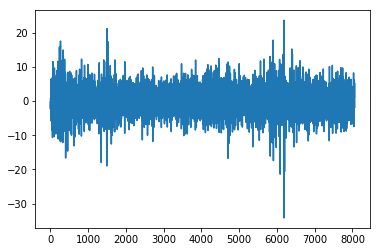

In [3]:
#画某个信号波形
plt.plot(CH10_df_EEG_x.iloc[0,:])
plt.show()

In [4]:
#多进程运行的函数
def runFFT(eegCH,startPoint,endPoint):
    ############################################################################
    #EEG DFT(FFT)频域数据    
    starttime = datetime.datetime.now()
    def eegFFT(df_data):
        eegfft_df = pd.DataFrame()
        for i in df_data.index.tolist():
            temp_eegfft = pd.DataFrame(np.fft.fft(df_data.loc[i,:].values)).T
            temp_eegfft.index = [i]
            eegfft_df = eegfft_df.append(temp_eegfft)
        return eegfft_df
    file_path = "./dump_file/CH{}_df_EEG_x".format(eegCH)
    locals()['CH{}_df_EEG_x'.format(eegCH)] = pickle.load(open(file_path,"rb"))
    ############################################################################   
    file_path = "./dump_file/CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)
    df = eegFFT(locals()['CH{}_df_EEG_x'.format(eegCH)].iloc[:,startPoint:endPoint])
    locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)] = df
    pickle.dump(locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)],open(file_path,"wb"))
    #用来计算程序运行时间
    endtime = datetime.datetime.now()
    print("程序运行时间（多进程）p%d:%.1fs"%(eegCH,(endtime - starttime).seconds))

          
#多进程编程 
startPoint = int((8064/63)*20)
endPoint = int((8064/63)*63)
if False:
    for eegCH in range(1,33,1):
        locals()["p{}".format(eegCH)] = multiprocessing.Process(target = runFFT, args = (eegCH,startPoint,endPoint))
        locals()["p{}".format(eegCH)].start()
        print("p{}.pid:{}".format(eegCH,locals()["p{}".format(eegCH)].pid))
else:
    for eegCH in range(1,33,1):        
        #file_path = "./dump_file/CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)
        #locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)] = pickle.load(open(file_path,"rb"))
        
        file_path = "./dump_file/CH{}eegfft_df".format(eeg_CH)
        locals()["CH{}eegfft_df".format(eegCH)] = pickle.load(open(file_path,"rb"))

#把不同时间范围的FFT文件做同一处理
for eegCH in range(1,33,1):
    #locals()["CH{}eegfft_df".format(eegCH)] = locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)]
    locals()["CH{}eegfft_df".format(eegCH)] = locals()["CH{}eegfft_df".format(eegCH)]

In [5]:
#EEG DFT(FFT)频域数据
def eegFFT(df_data):
    eegfft_df = pd.DataFrame()
    for i in df_data.index.tolist():
        temp_eegfft = pd.DataFrame(np.fft.fft(df_data.loc[i,:].values)).T
        temp_eegfft.index = [i]
        eegfft_df = eegfft_df.append(temp_eegfft)
    return eegfft_df

#画信号的频域图（通过FFT实现的频域）
def plotFreqSpectrum(df):
    fft_abs = abs(df)
    X = [(n-1)*128/8064 for n in range(1,8065,1) ]
    plt.plot(X,fft_abs)
    plt.xlabel("Hz")
    plt.ylabel("|X(k)|")
    #plt.title(u'某个EEG信号的频谱',fontproperties='SimHei')
    plt.show()

#调用画频谱图函数
#plotFreqSpectrum(CH1eegfft_df.iloc[1,:])

- FFT运算比较费时间，如果不是第一次运算，则直接读取dump的文件即可
- 将脑电分为5个带，每个通带计算功率谱特征
- delta 1-4Hz
- theta 4-8Hz
- alpha 8-14Hz
- beta  14-30Hz
- gamma 30-47Hz
- 巴特沃兹带通滤波器提取相应频带特征 
- |
- FFT到频域计算各频带的能量作为特征$b_{band}=\sum_{k=1}^N{|X_i(k)|^2}$

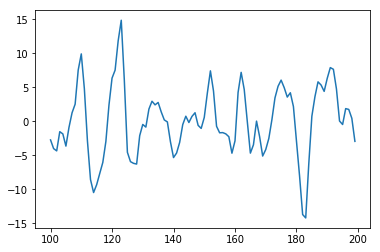

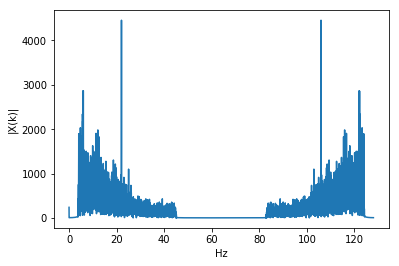

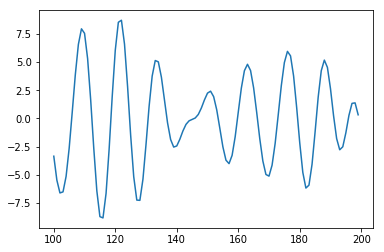

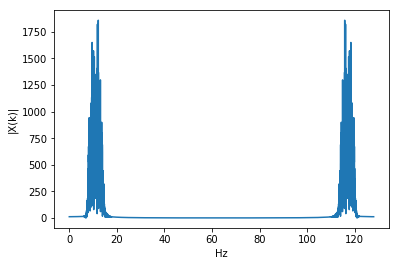

In [6]:
from scipy import signal
def butterBandPassFilter(data,lowcut,highcut,fs,order=5):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    b,a = signal.butter(order,[low,high],btype='bandpass')
    #y = signal.lfilter(b,a,data)
    y = signal.filtfilt(b,a,data)
    return y

#画滤波之前的信号波形
plt.plot(CH1_df_EEG_x.iloc[1,100:200])
plt.show()
#画滤波之前的频谱
plotFreqSpectrum(CH1eegfft_df.iloc[1,:])

'''
myWn = [(2*8)/128,(2*14)/128]
b,a = signal.butter(N=8,Wn=myWn ,btype='bandpass',analog=False,output='ba')
data = CH1_df_EEG_x.iloc[1,:]
filtedData = signal.filtfilt(b,a,data)   #data为要过滤的信号
filtedDataDF = pd.DataFrame(filtedData)
'''
data = CH1_df_EEG_x.iloc[1,:]
filtedData = butterBandPassFilter(data,8,14,fs=128,order=5)   #data为要过滤的信号
filtedDataDF = pd.DataFrame([filtedData])
#画滤波之后的信号波形
plt.plot(filtedDataDF.iloc[0,100:200])
plt.show()
#画滤波之后的频谱
filtedSpectrum = eegFFT(filtedDataDF)
plotFreqSpectrum(filtedSpectrum.iloc[0,:])

In [7]:
'''
#用来计算频率的分割点
starttime = datetime.datetime.now()
def countFerqHz(n):
    return (n-1)*128/8064
for n in range(1,8065,1):
    if countFerqHz(n)<4 and countFerqHz(n+1)>=4:
        print("theta_low_n:%d"%(n+1))
    if countFerqHz(n)<8 and countFerqHz(n+1)>=8:
        print("theta_high_n:%d"%(n))
        print("alpha_low_n:%d"%(n+1))
    if countFerqHz(n)<14 and countFerqHz(n+1)>=14:
        print("alpha_high_n:%d"%(n))
        print("beta_low_n:%d"%(n+1))
    if countFerqHz(n)<30 and countFerqHz(n+1)>=30:
        print("beta_high_n:%d"%(n))
        print("gamma_low_n:%d"%(n+1))
    if countFerqHz(n)<47 and countFerqHz(n+1)>=47:
        print("gamma_high_n:%d"%(n))
        
#用来计算程序运行时间
endtime = datetime.datetime.now()
print("程序运行时间:%.1fs"%(endtime - starttime).seconds)
'''
#theta:[253,504]
#alpha:[505,882]
#beta:[883,1890]
#gamma:[1891,2961]

'\n#用来计算频率的分割点\nstarttime = datetime.datetime.now()\ndef countFerqHz(n):\n    return (n-1)*128/8064\nfor n in range(1,8065,1):\n    if countFerqHz(n)<4 and countFerqHz(n+1)>=4:\n        print("theta_low_n:%d"%(n+1))\n    if countFerqHz(n)<8 and countFerqHz(n+1)>=8:\n        print("theta_high_n:%d"%(n))\n        print("alpha_low_n:%d"%(n+1))\n    if countFerqHz(n)<14 and countFerqHz(n+1)>=14:\n        print("alpha_high_n:%d"%(n))\n        print("beta_low_n:%d"%(n+1))\n    if countFerqHz(n)<30 and countFerqHz(n+1)>=30:\n        print("beta_high_n:%d"%(n))\n        print("gamma_low_n:%d"%(n+1))\n    if countFerqHz(n)<47 and countFerqHz(n+1)>=47:\n        print("gamma_high_n:%d"%(n))\n        \n#用来计算程序运行时间\nendtime = datetime.datetime.now()\nprint("程序运行时间:%.1fs"%(endtime - starttime).seconds)\n'

In [8]:
#早期的版本没有用滤波，直接软件筛选给个频带算通带能量特征
if False:
    def countPower(N,df):
        return np.square(abs(df)).sum(axis=1)

    eegFeatureDF = pd.DataFrame()
    for eegCH in range(1,33,1):
        '''E_band特征'''
        powerTheta = countPower(504-253+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,253:504+1])
        powerAlpha = countPower(882-505+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,505:882+1])
        powerBeta = countPower(1890-883+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,883:1890+1])
        powerGamma = countPower(2961-1891+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,1891:2961+1])
        powerThetaDF = pd.DataFrame(powerTheta,columns=["CH{}ThetaPower".format(eegCH)])   
        powerAlphaDF = pd.DataFrame(powerAlpha,columns=["CH{}AlphaPower".format(eegCH)])   
        powerBetaDF = pd.DataFrame(powerBeta,columns=["CH{}BetaPower".format(eegCH)])    
        powerGammaDF = pd.DataFrame(powerGamma,columns=["CH{}GammaPower".format(eegCH)])
        '''E_RPE特征,相对能量特征(Relative Power Energy,RPE)'''
        powerTotal = powerTheta + powerAlpha + powerBeta + powerGamma
        E_RPE_Theta = powerTheta / powerTotal
        E_RPE_Alpha = powerAlpha / powerTotal
        E_RPE_Beta = powerBeta / powerTotal
        E_RPE_Gamma = powerGamma / powerTotal
        E_RPE_ThetaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Theta".format(eegCH)])
        E_RPE_AlphaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Alpha".format(eegCH)])
        E_RPE_BetaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Beta".format(eegCH)])
        E_RPE_GammaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Gamma".format(eegCH)])
        '''E_LRPE特征,对数相对能量特征(Logarithmic Relative Power Energy,LRPE)'''
        E_LRPE_Theta = np.log(E_RPE_Theta)
        E_LRPE_Alpha = np.log(E_RPE_Alpha)
        E_LRPE_Beta = np.log(E_RPE_Beta)
        E_LRPE_Gamma = np.log(E_RPE_Gamma)
        E_LRPE_ThetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Theta".format(eegCH)])
        E_LRPE_AlphaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Alpha".format(eegCH)])
        E_LRPE_BetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Beta".format(eegCH)])
        E_LRPE_GammaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Gamma".format(eegCH)])
        '''E_ALRPE特征,对数绝对值相对能量特征(Absolute Logarithmic Relative Power Energy,ALRPE)'''
        E_ALRPE_Theta = abs(E_LRPE_Theta)
        E_ALRPE_Alpha = abs(E_LRPE_Alpha)
        E_ALRPE_Beta = abs(E_LRPE_Beta) 
        E_ALRPE_Gamma = abs(E_LRPE_Gamma)
        E_ALRPE_ThetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Theta".format(eegCH)])
        E_ALRPE_AlphaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Alpha".format(eegCH)])
        E_ALRPE_BetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Beta".format(eegCH)])
        E_ALRPE_GammaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Gamma".format(eegCH)])
        concatList = [eegFeatureDF,powerThetaDF,powerAlphaDF,powerBetaDF,powerGammaDF,
                      E_RPE_ThetaDF,E_RPE_AlphaDF,E_RPE_BetaDF,E_RPE_GammaDF,
                      E_LRPE_ThetaDF,E_LRPE_AlphaDF,E_LRPE_BetaDF,E_LRPE_GammaDF,
                      E_ALRPE_ThetaDF,E_ALRPE_AlphaDF,E_ALRPE_BetaDF,E_ALRPE_GammaDF,]
        eegFeatureDF = pd.concat(concatList,axis=1)


In [11]:
#滤波之后计算能量特征
def filteredCountPower(eegCH):
    starttime = datetime.datetime.now()
    from scipy import signal
    import os
    def butterBandPassFilter(data,lowcut,highcut,fs,order=5):
        nyq = 0.5*fs
        low = lowcut / nyq
        high = highcut / nyq
        b,a = signal.butter(order,[low,high],btype='bandpass')
        #y = signal.lfilter(b,a,data)
        y = signal.filtfilt(b,a,data)
        return y
    
    def eegFFT(df_data):
        eegfft_df = pd.DataFrame()
        for i in df_data.index.tolist():
            temp_eegfft = pd.DataFrame(np.fft.fft(df_data.loc[i,:].values)).T
            temp_eegfft.index = [i]
            eegfft_df = eegfft_df.append(temp_eegfft)
        return eegfft_df
    
    file_path = "./dump_file/CH{}_df_EEG_x".format(eegCH)
    locals()['CH{}_df_EEG_x'.format(eegCH)] = pickle.load(open(file_path,"rb"))
    #FFT计算费时间，第二次使用则可以直接读取文件，空间换时间
    for j in {"delta":[1,4],"theta":[4,8],"alpha":[8,14],"beta":[14,30],"gamma":[30,47]}:
    #for j in {"gamma":[30,47]}:
        if j == "delta":
            lowFreq,highFreq = 1,4
        if j == "theta":
            lowFreq,highFreq = 4,8
        if j == "alpha":
            lowFreq,highFreq = 8,14
        if j == "beta":
            lowFreq,highFreq = 14,30
        if j == "gamma":
            lowFreq,highFreq = 30,47
        print("[pid:{},CH:{}] filter {} now!".format(os.getpid(),eegCH,j))    
        filtedDataDF = pd.DataFrame()
        for i in range(0,1280,1):
            if i % 500 == 0:
                print("CH{}:{}".format(eegCH,i))
            data = locals()['CH{}_df_EEG_x'.format(eegCH)].iloc[i,:]
            filtedData = butterBandPassFilter(data,lowFreq,highFreq,fs=128,order=5)   #data为要过滤的信号
            df = pd.DataFrame([filtedData])
            filtedDataDF = pd.concat([filtedDataDF,df],axis=0)
        filtedDataDF.index = locals()['CH{}_df_EEG_x'.format(eegCH)].index
        filePath = "./dump_file/CH{}filtedEEG_FFT_{}".format(eegCH,j)
        pickle.dump(eegFFT(filtedDataDF),open(filePath,"wb"))
        print("[pid:{},CH:{}] filter & fft {} done!".format(os.getpid(),eegCH,j))   
    endtime = datetime.datetime.now()
    print("程序运行时间（多进程）p%d:%.1fs"%(eegCH,(endtime - starttime).seconds))


if False:
    for eegCH in range(1,33,1):
        p = multiprocessing.Process(target = filteredCountPower, args = (eegCH,))
        p.start()
        #print("p.pid:{}".format(p.pid),end=" ")
else:
    for j in {"delta":[1,4],"theta":[4,8],"alpha":[8,14],"beta":[14,30],"gamma":[30,47]}:
        for eegCH in range(1,33,1):
            #print("CH{}filtedEEG_FFT_{}".format(eegCH,j))
            filePath = "./dump_file/CH{}filtedEEG_FFT_{}".format(eegCH,j)
            locals()["CH{}filtedEEG_FFT_{}".format(eegCH,j)] = pickle.load(open(filePath,"rb")) 

#filteredCountPower(1)

CH1filtedEEG_FFT_delta
CH2filtedEEG_FFT_delta
CH3filtedEEG_FFT_delta
CH4filtedEEG_FFT_delta
CH5filtedEEG_FFT_delta
CH6filtedEEG_FFT_delta
CH7filtedEEG_FFT_delta
CH8filtedEEG_FFT_delta
CH9filtedEEG_FFT_delta
CH10filtedEEG_FFT_delta
CH11filtedEEG_FFT_delta
CH12filtedEEG_FFT_delta
CH13filtedEEG_FFT_delta
CH14filtedEEG_FFT_delta
CH15filtedEEG_FFT_delta
CH16filtedEEG_FFT_delta
CH17filtedEEG_FFT_delta
CH18filtedEEG_FFT_delta
CH19filtedEEG_FFT_delta
CH20filtedEEG_FFT_delta
CH21filtedEEG_FFT_delta
CH22filtedEEG_FFT_delta
CH23filtedEEG_FFT_delta
CH24filtedEEG_FFT_delta
CH25filtedEEG_FFT_delta
CH26filtedEEG_FFT_delta
CH27filtedEEG_FFT_delta
CH28filtedEEG_FFT_delta
CH29filtedEEG_FFT_delta
CH30filtedEEG_FFT_delta
CH31filtedEEG_FFT_delta
CH32filtedEEG_FFT_delta
CH1filtedEEG_FFT_theta
CH2filtedEEG_FFT_theta
CH3filtedEEG_FFT_theta
CH4filtedEEG_FFT_theta
CH5filtedEEG_FFT_theta
CH6filtedEEG_FFT_theta
CH7filtedEEG_FFT_theta
CH8filtedEEG_FFT_theta
CH9filtedEEG_FFT_theta
CH10filtedEEG_FFT_theta
CH11filted

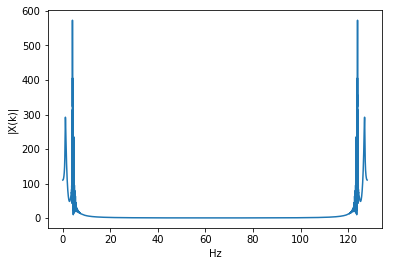

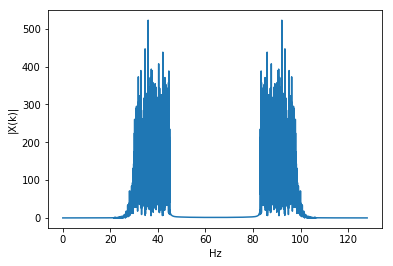

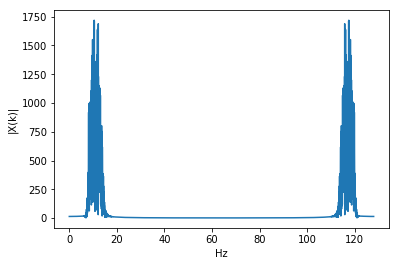

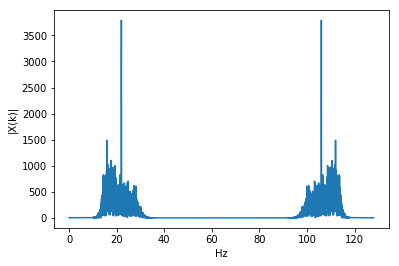

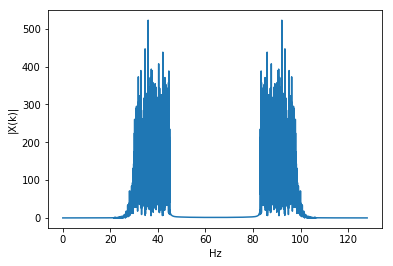

In [16]:
#{"delta":[1,4],"theta":[4,8],"alpha":[8,14],"beta":[14,30],"gamma":[30,47]}
plotFreqSpectrum(CH1filtedEEG_FFT_delta.iloc[0,:])
plotFreqSpectrum(CH1filtedEEG_FFT_theta.iloc[0,:])
plotFreqSpectrum(CH1filtedEEG_FFT_alpha.iloc[0,:])
plotFreqSpectrum(CH1filtedEEG_FFT_beta.iloc[0,:])
plotFreqSpectrum(CH1filtedEEG_FFT_gamma.iloc[0,:])

In [17]:
#用滤波，然后软件筛选给个频带算通带能量特征
#{"delta":[1,4],"theta":[4,8],"alpha":[8,14],"beta":[14,30],"gamma":[30,47]}
if True:
    def countPower(N,df):
        return np.square(abs(df)).sum(axis=1)

    eegFeatureDF = pd.DataFrame()
    for eegCH in range(1,33,1):
        '''E_band特征'''
        powerTheta = countPower(504-253+1,locals()["CH{}filtedEEG_FFT_theta".format(eegCH)].iloc[:,253:504+1])
        powerAlpha = countPower(882-505+1,locals()["CH{}filtedEEG_FFT_alpha".format(eegCH)].iloc[:,505:882+1])
        powerBeta = countPower(1890-883+1,locals()["CH{}filtedEEG_FFT_beta".format(eegCH)].iloc[:,883:1890+1])
        powerGamma = countPower(2961-1891+1,locals()["CH{}filtedEEG_FFT_gamma".format(eegCH)].iloc[:,1891:2961+1])
        powerThetaDF = pd.DataFrame(powerTheta,columns=["CH{}ThetaPower".format(eegCH)])   
        powerAlphaDF = pd.DataFrame(powerAlpha,columns=["CH{}AlphaPower".format(eegCH)])   
        powerBetaDF = pd.DataFrame(powerBeta,columns=["CH{}BetaPower".format(eegCH)])    
        powerGammaDF = pd.DataFrame(powerGamma,columns=["CH{}GammaPower".format(eegCH)])
        '''E_RPE特征,相对能量特征(Relative Power Energy,RPE)'''
        powerTotal = powerTheta + powerAlpha + powerBeta + powerGamma
        E_RPE_Theta = powerTheta / powerTotal
        E_RPE_Alpha = powerAlpha / powerTotal
        E_RPE_Beta = powerBeta / powerTotal
        E_RPE_Gamma = powerGamma / powerTotal
        E_RPE_ThetaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Theta".format(eegCH)])
        E_RPE_AlphaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Alpha".format(eegCH)])
        E_RPE_BetaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Beta".format(eegCH)])
        E_RPE_GammaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Gamma".format(eegCH)])
        '''E_LRPE特征,对数相对能量特征(Logarithmic Relative Power Energy,LRPE)'''
        E_LRPE_Theta = np.log(E_RPE_Theta)
        E_LRPE_Alpha = np.log(E_RPE_Alpha)
        E_LRPE_Beta = np.log(E_RPE_Beta)
        E_LRPE_Gamma = np.log(E_RPE_Gamma)
        E_LRPE_ThetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Theta".format(eegCH)])
        E_LRPE_AlphaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Alpha".format(eegCH)])
        E_LRPE_BetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Beta".format(eegCH)])
        E_LRPE_GammaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Gamma".format(eegCH)])
        '''E_ALRPE特征,对数绝对值相对能量特征(Absolute Logarithmic Relative Power Energy,ALRPE)'''
        E_ALRPE_Theta = abs(E_LRPE_Theta)
        E_ALRPE_Alpha = abs(E_LRPE_Alpha)
        E_ALRPE_Beta = abs(E_LRPE_Beta) 
        E_ALRPE_Gamma = abs(E_LRPE_Gamma)
        E_ALRPE_ThetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Theta".format(eegCH)])
        E_ALRPE_AlphaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Alpha".format(eegCH)])
        E_ALRPE_BetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Beta".format(eegCH)])
        E_ALRPE_GammaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Gamma".format(eegCH)])
        concatList = [eegFeatureDF,powerThetaDF,powerAlphaDF,powerBetaDF,powerGammaDF,
                      E_RPE_ThetaDF,E_RPE_AlphaDF,E_RPE_BetaDF,E_RPE_GammaDF,
                      E_LRPE_ThetaDF,E_LRPE_AlphaDF,E_LRPE_BetaDF,E_LRPE_GammaDF,
                      E_ALRPE_ThetaDF,E_ALRPE_AlphaDF,E_ALRPE_BetaDF,E_ALRPE_GammaDF,]
        eegFeatureDF = pd.concat(concatList,axis=1)


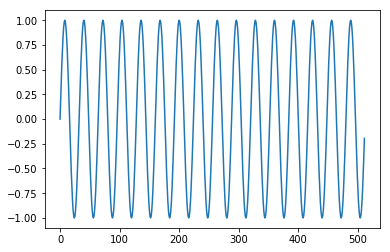

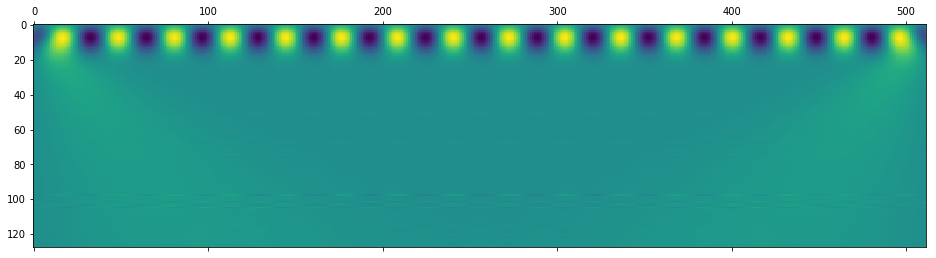

In [9]:
#coef, freqs = pywt.cwt(CH10_df_EEG_x.iloc[0,:],np.arange(1,5000),'gaus1')
#plt.matshow(coef) 
#plt.show()
'''
sig = CH1_df_EEG_x.iloc[0,:].values
widths = np.arange(1, 128)
cwtmatr, freqs = pywt.cwt(sig, widths, 'bior2.8')
plt.imshow(cwtmatr, extent=[0, 63, 1, 128], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.show() 
'''
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
plt.plot(x,y)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) 
plt.show() 

In [13]:
len(coef)

128

In [14]:
wavlist = pywt.wavelist(kind='continuous')
print(wavlist)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [18]:
print(eegFeatureDF.shape)
#dump到文件保存
pickle.dump(eegFeatureDF,open("./dump_file/eegFeatureDF","wb")) 


(1280, 512)
